In [1]:
#Rafael Aravena
#importamos las librerios pandas y numpy
import pandas as pd
import numpy as np

In [2]:
#Cargar los datos desde el csv
df = pd.read_csv('DatosFalsos.csv')

#Cambiamos el formato de le fecha de creacion a un formato legible por pandas
df.created_at = pd.to_datetime(df.created_at , format='%Y/%m/%d')

#imprimimos la cabecera del csv
df.head()

,id,created_at,updated_at,deleted_at,user_id,producto_id,pedido_id,tienda_id,faltante_id,nombre,unidad,precio,cantidad,cantidad_enviada,fecha_despacho,cantidad_anulada,cantidad_faltante,costo_actual
0,1,2022-07-07 06:27:17,2022-07-07 06:28:09,2022-07-07 06:28:09,24570,10,0,1,NaN,Cebolla morada,1 kg,1390,1.0,1.0,2022-07-08,NaN,0.0,NaN
1,2139665,2021-03-10 10:01:19,2021-03-10 16:15:17,2022-03-06 21:39:24,24252,1164,68834,1,NaN,Berros 100g,100 g,780,1.0,1.0,2024-02-01,NaN,0.0,NaN
2,3126362,2022-02-11 12:41:06,2022-02-11 12:56:37,NaN,31695,53,101286,1,NaN,Ciruelas,1 k,1590,2.5,2.5,2022-02-21,NaN,0.0,NaN
3,3126363,2022-02-11 12:41:06,2022-02-11 12:56:37,NaN,31695,232,101286,1,NaN,Durazno Nectarín,1 k,1990,3.0,3.0,2022-02-21,NaN,0.0,NaN
4,3126364,2022-02-11 12:41:06,2022-02-21 12:05:45,NaN,31695,233,101286,1,12310.0,Durazno Peludo,1 k,1990,3.0,3.0,2022-02-21,NaN,3.0,NaN


In [3]:
#Se crea un nueva columna donde se almacenara la fecha de creacion del pedido, con esto posteriormente se creara los cohortes
df['Periodo'] = df.created_at.apply(lambda x: x.strftime('%Y-%m'))

#Vamos a definir los id de los usuarios como indice 
df.set_index('user_id', inplace = True)

#Creamos los cohortes para los meses, con la funcion min se obtiene el primer mes registrado para cada usuario
df['CohortGrupo'] = df.groupby(level = 0)['created_at'].min().apply(lambda x: x.strftime('%Y-%m'))

#se reinician los indices
df.reset_index(inplace = True)
df.head()

,user_id,id,created_at,updated_at,deleted_at,producto_id,pedido_id,tienda_id,faltante_id,nombre,unidad,precio,cantidad,cantidad_enviada,fecha_despacho,cantidad_anulada,cantidad_faltante,costo_actual,Periodo,CohortGrupo
0,24570,1,2022-07-07 06:27:17,2022-07-07 06:28:09,2022-07-07 06:28:09,10,0,1,NaN,Cebolla morada,1 kg,1390,1.0,1.0,2022-07-08,NaN,0.0,NaN,2022-07,2022-03
1,24252,2139665,2021-03-10 10:01:19,2021-03-10 16:15:17,2022-03-06 21:39:24,1164,68834,1,NaN,Berros 100g,100 g,780,1.0,1.0,2024-02-01,NaN,0.0,NaN,2021-03,2021-03
2,31695,3126362,2022-02-11 12:41:06,2022-02-11 12:56:37,NaN,53,101286,1,NaN,Ciruelas,1 k,1590,2.5,2.5,2022-02-21,NaN,0.0,NaN,2022-02,2022-02
3,31695,3126363,2022-02-11 12:41:06,2022-02-11 12:56:37,NaN,232,101286,1,NaN,Durazno Nectarín,1 k,1990,3.0,3.0,2022-02-21,NaN,0.0,NaN,2022-02,2022-02
4,31695,3126364,2022-02-11 12:41:06,2022-02-21 12:05:45,NaN,233,101286,1,12310.0,Durazno Peludo,1 k,1990,3.0,3.0,2022-02-21,NaN,3.0,NaN,2022-02,2022-02


In [4]:
#Agrupamos los cortes por mes
grouped = df.groupby(['CohortGrupo' , 'Periodo'])

#Contamos los usuarios unicos con sus pedidos y el precio por grupo
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'pedido_id': pd.Series.nunique,
                      'precio': np.sum})
cohorts.head()

user_id  pedido_id    precio
CohortGrupo Periodo                              
2021-03     2021-03        1          1       780
2022-02     2022-02     1188       1532  50067795
            2022-03      753       1985  71062626
            2022-04      614       1543  59223374
            2022-05      603       1520  58752259

In [5]:
#Creamos una serie que contenga el tamaño total de cada grupo de cohortes
cohort_group_size = cohorts['user_id'].groupby(level = 0).first()
cohort_group_size.head()

CohortGrupo
2021-03       1
2022-02    1188
2022-03    1447
2022-04     792
2022-05     862
Name: user_id, dtype: int64

In [6]:
#Creamos la matris de retencion con los datos enteros
retencion = cohorts['user_id'].unstack(0)
retencion.head()

CohortGrupo,2021-03,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Periodo,,,,,,,,,,,,,,,,,,,,
2021-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,NaN,1188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03,NaN,753.0,1447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04,NaN,614.0,554.0,792.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05,NaN,603.0,513.0,298.0,862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Usando la matriz anterior podemos crear la matris de retencion porcentual
retencionp = cohorts['user_id'].unstack(0).divide(cohort_group_size, axis = 1)
retencionp.head()

CohortGrupo,2021-03,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Periodo,,,,,,,,,,,,,,,,,,,,
2021-03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03,NaN,0.633838,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04,NaN,0.516835,0.382861,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05,NaN,0.507576,0.354527,0.376263,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


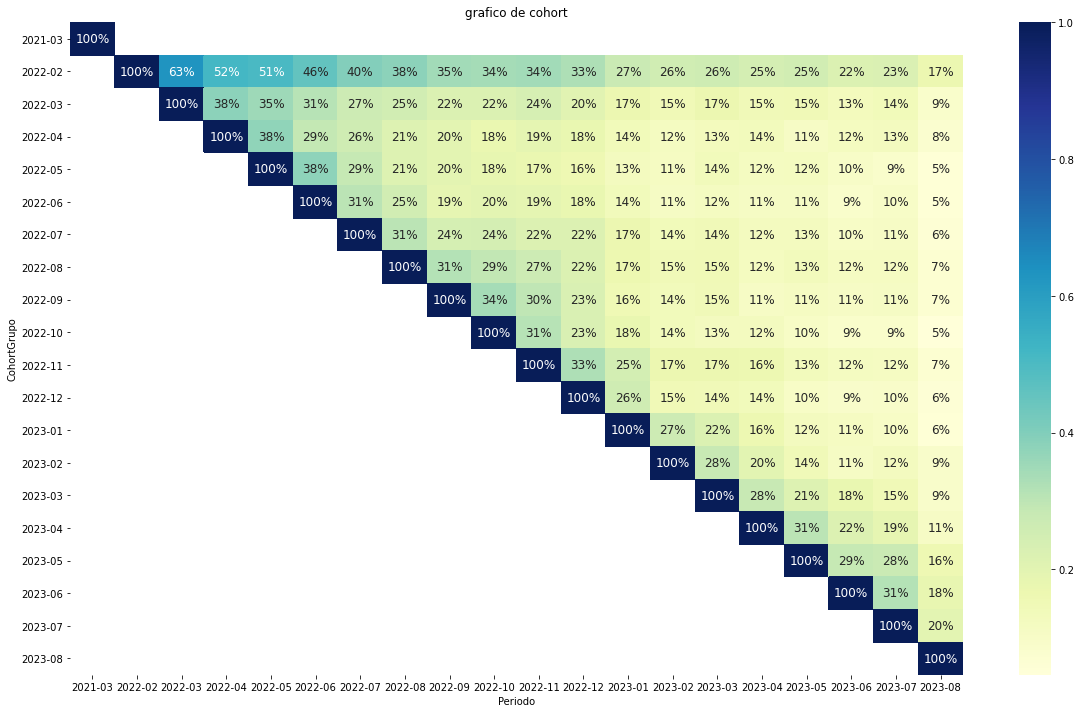

In [8]:
#Transponemos la matris de retencion porcentual para mejorar su visualizacion
datareten = retencionp.T

#importamos la librerias para graficar y para crear el mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

#Se configura el grafico
plt.figure(figsize = (20 , 12))
plt.title('grafico de cohort')

#Se configura el mapa de calor
sns.heatmap(data = datareten , annot = True, fmt = ".0%" , annot_kws = {'size':12} , cbar = True , cmap = 'YlGnBu')

#Se imprime el grafico
b , t = plt.ylim() #descubra los valores de bottom y top
plt.ylim(b , t)
plt.show()

Analizando el grafico de retención podemos ver en primera instancia que como en todos los servicios la retención va disminuyendo con el tiempo, lo importante es ver si esta retención esta dentro de los márgenes tolerables, desde febrero de 2022 a marzo de 2022 se logra observar una retención del 63% de los usuarios, una cifra bastante alta que puede evidenciar la alta preferencia servicio en análisis, en los consiguientes meses también se observa una alta retención en abril hay una retención del 52% de enero y 38% de marzo, lo cual nos puede indicar que una parte significativa de los clientes tiene una alta probabilidad de seguir solicitando el servicio entregado. Estos números de retención se mantiene bastante similares hasta enero de 2023 donde se observa una evidencia caída, la retención del mes anterior solo logra el 26% la mas baja en todo el grafico, pero también en los consiguientes meses del 2023 la retención va aumentando poco a poco hasta llegar a junio donde vuelve a retomar los valores cercanos al 30% que presentaba el año anterior.
Una conclusión que se puede obtener es que parte importante de los clientes que adquieren el servicio vuelven a solicitarlo los meses siguientes y que se puede asegurar que en promedio que 30% de los clientes se mantendrán como clientes fieles al servicio

Text(0.5, 1.0, 'Cantidad de Ventas')

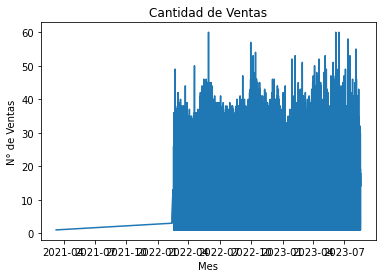

In [9]:
X = {'Mes': df['created_at'], 'Ventas': df['pedido_id']}
F = pd.DataFrame(X)
F = F.groupby(by=['Mes'], as_index=False).count()

plt.plot(F['Mes'], F['Ventas'])
plt.xlabel('Mes')
plt.ylabel('N° de Ventas')
plt.title('Cantidad de Ventas')

Text(0.5, 1.0, 'Cantidad de Ventas')

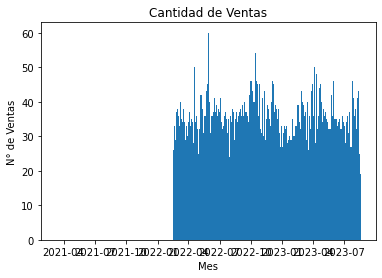

In [10]:
plt.bar(F['Mes'], F['Ventas'])
plt.xlabel('Mes')
plt.ylabel('N° de Ventas')
plt.title('Cantidad de Ventas')

Text(0.5, 1.0, 'Cantidad de Ventas')

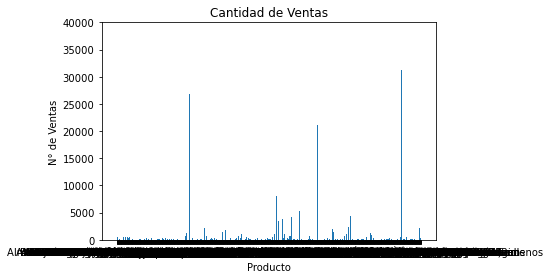

In [11]:
X = {'Producto': df['nombre'], 'Ventas': df['pedido_id']}
F = pd.DataFrame(X)
F = F.groupby(by=['Producto'], as_index=False).count()

plt.bar(F['Producto'], F['Ventas'])
plt.xlabel('Producto')
plt.ylabel('N° de Ventas')
plt.title('Cantidad de Ventas')